In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/DeepFake_Detection
%load_ext tensorboard

Mounted at /content/drive
/content/drive/MyDrive/DeepFake_Detection


# Imports

In [2]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, ReLU, ELU, LeakyReLU, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from math import floor, log
from datetime import datetime
import os

In [3]:
IMG_WIDTH = 256

# Data

In [4]:
def get_datagen(use_default_augmentation=True, **kwargs):
    kwargs.update({'rescale': 1./255})
    if use_default_augmentation:
        kwargs.update({
            'rotation_range': 15,
            'zoom_range': 0.2,
            'brightness_range': (0.8, 1.2),
            'channel_shift_range': 30,
            'horizontal_flip': True,
        })
    return ImageDataGenerator(**kwargs)

In [5]:
def get_train_data_generator(
    train_data_dir, 
    batch_size, 
    validation_split=None, 
    use_default_augmentation=True,
    augmentations=None
):
    if not augmentations:
        augmentations = {}

    train_datagen = get_datagen(
        use_default_augmentation=use_default_augmentation,
        validation_split=validation_split if validation_split else 0.0,
        **augmentations
    )
   
    train_generator = train_datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
    )

    validation_generator = None

    if validation_split:
        validation_generator = train_datagen.flow_from_directory(
            directory=train_data_dir,
            target_size=(IMG_WIDTH, IMG_WIDTH),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
        )

    return train_generator, validation_generator

In [6]:
def get_test_data_generator(test_data_dir, batch_size, shuffle=False):
    test_datagen = get_datagen(use_default_augmentation=False)
    return test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )

# Model

In [7]:
def activation_layer(ip, activation, *args):
    return {'relu': ReLU(*args)(ip),
            'elu': ELU(*args)(ip),
            'lrelu': LeakyReLU(*args)(ip)}[activation]

In [8]:
def conv2D(ip,
           filters,
           kernel_size,
           activation,
           padding='same',
           pool_size=(2, 2)):
    layer = Conv2D(filters,
                   kernel_size=kernel_size,
                   padding=padding)(ip)

    layer = activation_layer(layer, activation=activation)

    layer = BatchNormalization()(layer)

    return MaxPooling2D(pool_size=pool_size, padding=padding)(layer)

In [9]:
def fully_connected_layer(ip,
                          hidden_activation,
                          dropout):
    layer = Dense(16)(ip)
    layer = activation_layer(layer, hidden_activation, *[0.1,])
    return Dropout(rate=dropout)(layer)

In [10]:
def build_model(ip=Input(shape=(IMG_WIDTH, IMG_WIDTH, 3)),
                activation='relu',
                dropout=0.5,
                hidden_activation='lrelu'):
    
    layer = conv2D(ip, filters=8, kernel_size=(3, 3), activation=activation)

    layer = conv2D(layer, filters=8, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation, pool_size=(4, 4))

    layer = Flatten()(layer)
    layer = Dropout(rate=dropout)(layer)

    layer = fully_connected_layer(layer, hidden_activation=hidden_activation, dropout=dropout)

    op_layer = Dense(1, activation='sigmoid')(layer)

    model = Model(ip, op_layer)

    return model

In [11]:
def evaluate_model(model, test_data_dir, batch_size):
    data = get_test_data_generator(test_data_dir, batch_size)
    return model.evaluate(data)


def predict(model, data, steps=None, threshold=0.5):
    predictions = model.predict(data, steps=steps, verbose=1)
    return predictions, np.where(predictions >= threshold, 1, 0)


def save_model_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

In [ ]:
def get_activation_model(model, conv_idx):
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    selected_layers = [layer for index, layer in enumerate(conv_layers) if index in conv_idx]
    activation_model = Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in selected_layers]
    )
    return activation_model

# Visualization

In [12]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'], 'r', label='train')
    plt.plot(history.history['val_loss'], 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [13]:
def get_classification_report(
    model, data_dir, batch_size=64,
    steps=None, threshold=0.5, output_dict=False
):
    data = get_test_data_generator(data_dir, batch_size=batch_size)
    predictions = predict(model, data, steps, threshold)
    predictions = predictions.reshape((predictions.shape[0],))
    return classification_report(data.classes, predictions, output_dict=output_dict)

In [14]:
def visualize_conv_layers_single_img(
    activations,
    conv_idx,
):
    images_per_row = 4

    for activation, idx in zip(activations, conv_idx):
        num_filters = activation.shape[-1]

        imgs = [activation[:, :, i] for i in range(num_filters)]

        num_rows = num_filters // images_per_row

        fig = plt.figure()
        grid = ImageGrid(fig, 111, (num_rows, images_per_row))

        for ax, im in zip(grid, imgs):
            ax.imshow(im, cmap='viridis')

        plt.title(f'Convolutional Layer {idx + 1}')
        plt.show()


def visualize_conv_layers(model, imgs, conv_idx):
    activation_model = get_activation_model(model, conv_idx)
    activations = activation_model.predict(imgs)

    num_imgs = imgs.shape[0]
    num_layers = len(conv_idx)

    for idx in range(num_imgs):
        img_activs = [activations[i][idx, :, :, :] for i in range(num_layers)]
        visualize_conv_layers_single_img(
            activations=img_activs, conv_idx=conv_idx
        )

# Training

In [15]:
def train_model(model,
                train_data_dir,
                validation_split=None,
                batch_size=32,
                use_default_augmentation=True,
                augmentations=None,
                epochs=30,
                lr=1e-3,
                loss='binary_crossentropy',
                compile=True,
                lr_decay=True,
                decay_rate=0.10,
                decay_limit=1e-6,
                checkpoint=True,
                stop_early=True,
                monitor='val_accuracy',
                mode='max',
                patience=20,
                tensorboard=True,
                loss_curve=True):
    
    run_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    train_generator, validation_generator = get_train_data_generator(
        train_data_dir=train_data_dir,
        batch_size=batch_size,
        validation_split=validation_split,
        use_default_augmentation=use_default_augmentation,
        augmentations=augmentations
    )

    callbacks = []
    if checkpoint:
        filepath = f'run_{run_time}_best_model.hdf5'
        model_checkpoint = ModelCheckpoint(
            filepath, monitor='val_accuracy', verbose=1,
            save_best_only=True
        )
        callbacks.append(model_checkpoint)

    if stop_early:
        callbacks.append(
            EarlyStopping(
                monitor=monitor,
                mode=mode,
                patience=patience,
                verbose=1
            )
        )

    if tensorboard:
        log_dir = "logs/fit/" + run_time
        callbacks.append(TensorBoard(log_dir, histogram_freq=1, write_images=True))

    if compile:
        if lr_decay:
            num_times = floor(log(decay_limit / lr, decay_rate))
            per_epoch = epochs // num_times
            lr = ExponentialDecay(
                lr,
                decay_steps=(train_generator.samples // batch_size) * per_epoch,
                decay_rate=decay_rate,
                staircase=True,
            )
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size if validation_generator else None,
    )

    if loss_curve:
        plot_loss_curve(history)

    return history

# Driver (Main)

In [16]:
def main():
    train_data_dir = 'data/train/'
    val_split, epochs, batch_size = 0.20, 50, 64
    decay_rate, decay_limit = 0.10, 1e-6
    model = build_model()
    return model, train_model(
        model,
        train_data_dir,
        validation_split=val_split,
        epochs=epochs,
        decay_rate=decay_rate,
        decay_limit=decay_limit,
    )

# !rm -rf logs
# %tensorboard --logdir logs/fit
# model, history = main()

# Model Evaluation

## 11th Model

In [ ]:
model_exp = load_model('final_selected_model/experiment11_run_20210331-102658_best_model.hdf5')

In [ ]:
evaluate_model(model_exp, 'data/test', 64)

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 7s 235ms/step - loss: 0.0998 - accuracy: 0.9625


[0.09982584416866302, 0.9624678492546082]

In [ ]:
print(get_classification_report(model_exp, 'data/test'))

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 7s 235ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       773
           1       0.96      0.97      0.97      1172

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945



## 4th Model

In [ ]:
model_exp = load_model('second_best_model/saved_model')

In [ ]:
evaluate_model(model_exp, 'data/test', 64)

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 8s 241ms/step - loss: 0.2321 - accuracy: 0.9080


[0.23209184408187866, 0.9079691767692566]

In [ ]:
print(get_classification_report(model_exp, 'data/test'))

Found 1945 images belonging to 2 classes.
31/31 [==============================] - 7s 234ms/step
              precision    recall  f1-score   support

           0       0.90      0.87      0.88       773
           1       0.91      0.93      0.92      1172

    accuracy                           0.91      1945
   macro avg       0.91      0.90      0.90      1945
weighted avg       0.91      0.91      0.91      1945



# Testing Hidden Layer Visualization

Found 1945 images belonging to 2 classes.


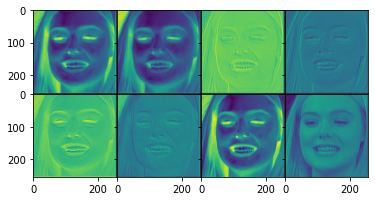

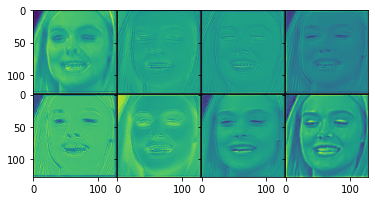

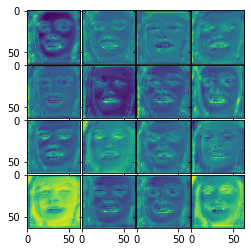

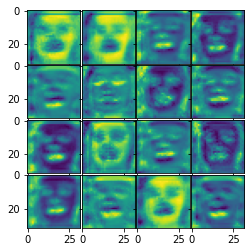

In [31]:
model_exp = load_model('second_best_model/saved_model')
number_of_images = 1
data = get_test_data_generator('data/test', number_of_images, shuffle=True)
batch_idx = np.random.randint(0, data.samples // data.batch_size)
imgs, labels = data[batch_idx]
visualize_conv_layers(model_exp, imgs, [0, 1, 2, 3])